In [48]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input

tf.__version__

'1.14.0'

In [49]:
os.listdir('./data')

['DJI_ema.csv',
 'DJI_STO_20period_sma10.csv',
 'DJI_modified_sma.csv',
 '.DS_Store',
 'DJI_modified_features - DJI.csv',
 '.~lock.nk_fe.csv#',
 'nk_fe.csv',
 'DJI_fe.csv',
 'N225withoutNULL.csv',
 'dowjone1985_2019.csv',
 'N225fillVOL.csv',
 'test_djia.csv',
 'DJI_denoise.csv',
 'N225.csv',
 'stocknews',
 'preprocessed',
 'downjone5y.csv']

In [50]:
print("\n".join(os.listdir("./")))
df = pd.read_csv('data/nk_fe.csv')

djia_support_nikkei_sync_period.ipynb
Simulator
Graph
DJI_STO_20period_sma10.csv
stock_with_news.ipynb
sentiment_roc_curve.ipynb
model_FE.ipynb
.git
Nikkie_NoFE.ipynb
loss_support_sync_data.png
.DS_Store
README.md
djia_support_nikkei.ipynb
ARIMA_model.ipynb
Paper.zip
utils.py
__pycache__
baseline.ipynb
loss_support_sync_data2.png
djia_support_nikkei-test.ipynb
djia_support_nikkei_sync_period_V2.ipynb
embedding_model.h5
seq2word_seq2seq.ipynb
AIAlpha.ipynb
Paper
preprocess
model_nk_wo_fe.ipynb
.ipynb_checkpoints
data
join DJI and Nikkei.ipynb
saved_model
tmp
model_fe_too.ipynb


In [51]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sma_5,sma_10,sma_25,sma_75,sma_125,sma_200
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570
3,1985-02-01,11946.959961,11946.959961,11946.959961,11946.959961,11946.959961,0,11946.959961,11946.959961,11946.959961,11946.959961,11946.959961,11946.959961
4,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0,11926.809961,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078


In [52]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,sma_5,sma_10,sma_25,sma_75,sma_125,sma_200
count,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000
mean,17127.378178,17230.332515,17015.456662,17123.019021,17123.019021,59729.515766,17120.552265,17117.490010,17109.147717,17084.157882,17060.805309,17024.401278
std,6094.196832,6114.941481,6070.241283,6093.569176,6093.569176,71179.395395,6089.953199,6086.367550,6075.660388,6037.920485,5999.243651,5939.190676
min,7059.770020,7100.770020,6994.899902,7054.979980,7054.979980,0.000000,7177.695996,7269.122021,7472.499980,8042.698769,8246.958504,8503.695293
25%,12331.404785,12386.577393,12270.609619,12321.304932,12321.304932,0.000000,12346.151953,12370.501782,12367.507236,12348.460104,12285.792297,12156.326215
50%,16802.924804,16923.285157,16656.660156,16790.860352,16790.860352,0.000000,16784.417969,16776.911523,16732.064141,16691.359955,16783.288875,16903.481450
75%,20442.700684,20560.332519,20328.775391,20454.067871,20454.067871,117200.000000,20440.779687,20431.668897,20394.477109,20245.853861,20072.144027,19774.971782
max,38921.648438,38957.441406,38827.710938,38915.871094,38915.871094,595200.000000,38908.085156,38743.462500,38365.409688,37388.689948,36462.073594,35550.711504


In [53]:
df = df.drop('Adj Close', axis=1)

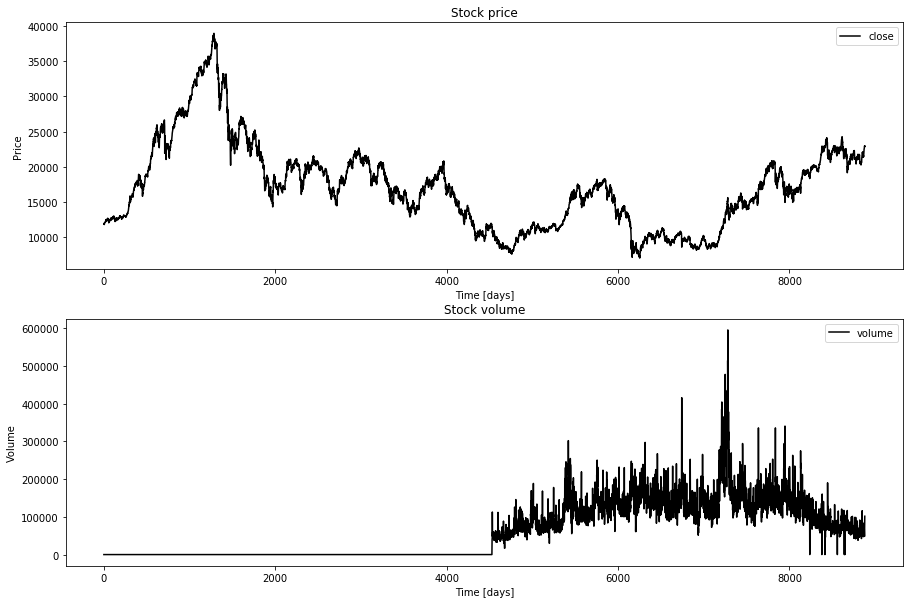

In [54]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(df['Close'], color='black', label='close')
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')


plt.subplot(2, 1, 2)
plt.plot(df['Volume'], color='black', label='volume')
plt.title('Stock volume')
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best')

In [61]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Open'].to_numpy().reshape(-1, 1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].to_numpy().reshape(-1, 1))    
    df['High'] = min_max_scaler.fit_transform(df['High'].to_numpy().reshape(-1, 1))    
    df['Close'] = min_max_scaler.fit_transform(df['Close'].to_numpy().reshape(-1, 1))
    df['sma_5'] = min_max_scaler.fit_transform(df['sma_5'].to_numpy().reshape(-1, 1))
    df['sma_10'] = min_max_scaler.fit_transform(df['sma_10'].to_numpy().reshape(-1, 1))
    df['sma_25'] = min_max_scaler.fit_transform(df['sma_25'].to_numpy().reshape(-1, 1))
    df['sma_75'] = min_max_scaler.fit_transform(df['sma_75'].to_numpy().reshape(-1, 1))
    df['sma_125'] = min_max_scaler.fit_transform(df['sma_125'].to_numpy().reshape(-1, 1))
    df['sma_200'] = min_max_scaler.fit_transform(df['sma_200'].to_numpy().reshape(-1, 1))
    #df['Volume'] = min_max_scaler.fit_transform(df['Volume'].to_numpy().reshape(-1, 1))  
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [62]:
df_index = df.drop('Date', axis=1)
df_index = df_index.drop('Volume', axis=1)


cols = list(df_index.columns.values)
print('Col : ', cols)

# rearrange columns ,for training with volume
# n_cols = cols[:3] + [cols[-1]] + [cols[-2]]
# df_index = df_index[n_cols] 

# print("new Cols: ",list(df_index.columns.values))





# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_index_norm = normalize_data(df_index)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_index_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

Col :  ['Open', 'High', 'Low', 'Close', 'sma_5', 'sma_10', 'sma_25', 'sma_75', 'sma_125', 'sma_200']
x_train.shape =  (7088, 19, 10)
y_train.shape =  (7088, 10)
x_val.shape =  (886, 19, 10)
y_val.shape =  (886, 10)
x_test.shape =  (886, 19, 10)
y_test.shape =  (886, 10)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [63]:
print(y_train[0]);
print("\n")
print(x_train[0]); 

[0.16136117 0.16010053 0.16354635 0.16151651 0.15692899 0.15417981
 0.15306231 0.14170049 0.14014054 0.13670065]


[[0.15012612 0.14886365 0.15230105 0.15028112 0.14703174 0.14532309
  0.14147487 0.12950224 0.12745338 0.12346556]
 [0.15381579 0.15255391 0.15599408 0.15397089 0.15073669 0.14905818
  0.14528026 0.13350822 0.13161993 0.12781205]
 [0.15481007 0.15354836 0.15698927 0.15496521 0.15173509 0.1500647
  0.14630573 0.13458775 0.13274272 0.12898333]
 [0.15338675 0.15212481 0.15556465 0.15354184 0.15030588 0.14862386
  0.14483776 0.1330424  0.13113544 0.12730664]
 [0.15163293 0.1503707  0.15380923 0.15178797 0.14967084 0.14684845
  0.14302894 0.13113823 0.12915494 0.12524061]
 [0.14950969 0.14824712 0.15168405 0.14966467 0.14954704 0.14469907
  0.1408391  0.12883296 0.12675728 0.12273939]
 [0.1508825  0.14962015 0.15305811 0.15103752 0.14895795 0.14608878
  0.14225497 0.13032346 0.12830752 0.12435659]
 [0.15319341 0.15193143 0.15537113 0.1533485  0.14863328 0.14842814
  0.14463836 

In [64]:
df_index.head(20)

,Open,High,Low,Close,sma_5,sma_10,sma_25,sma_75,sma_125,sma_200
0,0.150126,0.148864,0.152301,0.150281,0.147032,0.145323,0.141475,0.129502,0.127453,0.123466
1,0.153816,0.152554,0.155994,0.153971,0.150737,0.149058,0.145280,0.133508,0.131620,0.127812
2,0.154810,0.153548,0.156989,0.154965,0.151735,0.150065,0.146306,0.134588,0.132743,0.128983
3,0.153387,0.152125,0.155565,0.153542,0.150306,0.148624,0.144838,0.133042,0.131135,0.127307
4,0.151633,0.150371,0.153809,0.151788,0.149671,0.146848,0.143029,0.131138,0.129155,0.125241
5,0.149510,0.148247,0.151684,0.149665,0.149547,0.144699,0.140839,0.128833,0.126757,0.122739
6,0.150883,0.149620,0.153058,0.151038,0.148958,0.146089,0.142255,0.130323,0.128308,0.124357
7,0.153193,0.151931,0.155371,0.153348,0.148633,0.148428,0.144638,0.132832,0.130917,0.127079
8,0.155334,0.154073,0.157514,0.155489,0.149024,0.150595,0.146846,0.135157,0.133335,0.129601
9,0.155334,0.154073,0.157514,0.155489,0.149768,0.148032,0.146846,0.135157,0.133335,0.129601


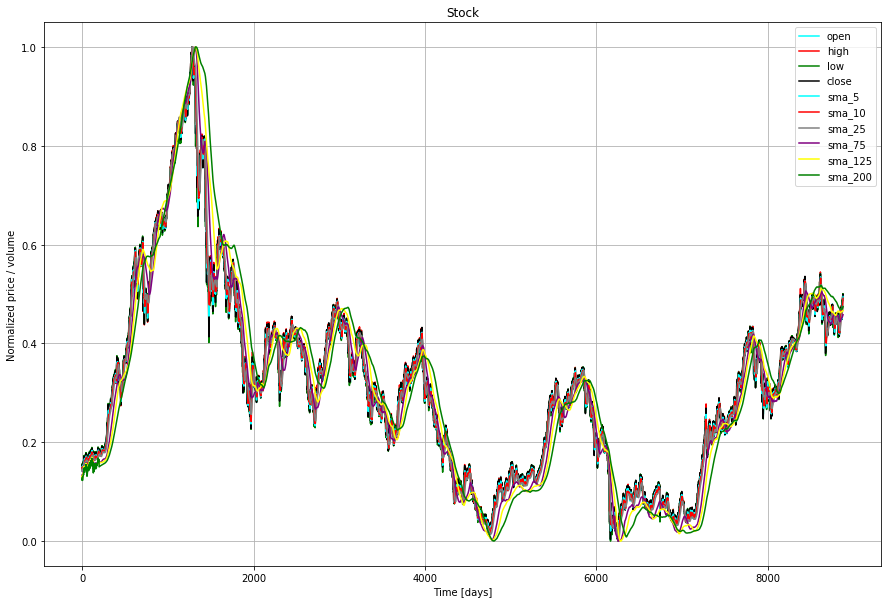

In [65]:
plt.figure(figsize=(15, 10))
plt.grid(True)
plt.plot(df_index_norm['Open'], color='cyan', label='open')
plt.plot(df_index_norm['High'], color='red', label='high')
plt.plot(df_index_norm['Low'], color='green', label='low')
plt.plot(df_index_norm['Close'], color='black', label='close')
plt.plot(df_index_norm['sma_5'], color='cyan', label='sma_5')
plt.plot(df_index_norm['sma_10'], color='red', label='sma_10')
plt.plot(df_index_norm['sma_25'], color='gray', label='sma_25')
plt.plot(df_index_norm['sma_75'], color='purple', label='sma_75')
plt.plot(df_index_norm['sma_125'], color='yellow', label='sma_125')
plt.plot(df_index_norm['sma_200'], color='green', label='sma_200')
plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend(loc='best')
plt.show()

In [66]:
from tensorflow.keras import backend as K
K.clear_session()

In [71]:
from tensorflow.keras.layers import Bidirectional,TimeDistributed,BatchNormalization,Flatten,LeakyReLU,Dropout

def get_bi_gru():
    
    input1 = Input(shape=(19,10,))
    x = Bidirectional(LSTM(256, return_sequences=True,  kernel_initializer='Orthogonal'))(input1)
    x = TimeDistributed(LeakyReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = GRU(128,kernel_initializer='Orthogonal')(x)
    x =(LeakyReLU())(x)
    x = (BatchNormalization())(x)
    x = (Dropout(0.25))(x)
    out = Dense(10,kernel_initializer='he_normal')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.005),
                loss='mse',
                metrics=['mse'])   
    
    return model

In [72]:
model = get_bi_gru()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 19, 10)]          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 19, 512)           546816    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 19, 512)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 19, 512)           2048      
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               246144    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
print('start training ')


weight_path_model = "saved_model/model_sma_NoVOL.h5"
callbacks_list_model = [
    ModelCheckpoint(
             weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, min_lr=0.0001)
]

#################
batch_size = 64
epochs = 300
#################

history = model.fit(x_train, y_train, epochs=epochs, verbose=1, callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) #batch_size=batch_size




start training 
Train on 7088 samples, validate on 886 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.1998 - mean_squared_error: 0.1998
Epoch 00001: val_loss improved from inf to 0.25186, saving model to saved_model/model_sma_NoVOL.h5
7088/7088 [==============================] - 13s 2ms/sample - loss: 0.1985 - mean_squared_error: 0.1985 - val_loss: 0.2519 - val_mean_squared_error: 0.2519
Epoch 2/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 00002: val_loss improved from 0.25186 to 0.07149, saving model to saved_model/model_sma_NoVOL.h5
7088/7088 [==============================] - 12s 2ms/sample - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0715 - val_mean_squared_error: 0.0715
Epoch 3/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049
Ep

7040/7088 [============================>.] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 00024: val_loss improved from 0.00399 to 0.00323, saving model to saved_model/model_sma_NoVOL.h5
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 25/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 00025: val_loss did not improve from 0.00323
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 26/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 00026: val_loss did not improve from 0.00323
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 27/3

7040/7088 [============================>.] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 00049: val_loss did not improve from 0.00083
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 50/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 00050: val_loss did not improve from 0.00083
7088/7088 [==============================] - 15s 2ms/sample - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 51/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 00051: val_loss did not improve from 0.00083
7088/7088 [==============================] - 15s 2ms/sample - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 52/300
7040/7088 [============================>.] - ETA:

7040/7088 [============================>.] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 00074: val_loss did not improve from 0.00021
7088/7088 [==============================] - 15s 2ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 75/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 00075: val_loss did not improve from 0.00021
7088/7088 [==============================] - 15s 2ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 76/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 00076: val_loss did not improve from 0.00021
7088/7088 [==============================] - 15s 2ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 77/300
7040/7088 [============================>.] - ETA:

Epoch 100/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 00100: val_loss did not improve from 0.00019
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 101/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 00101: val_loss did not improve from 0.00019
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.7757e-04 - val_mean_squared_error: 3.7757e-04
Epoch 102/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 00102: val_loss did not improve from 0.00019
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 2.3747e-04 - val_mean_squared_error: 2.3747e-04
Epoch 103/300
7040/7088 [=====

7040/7088 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 00125: val_loss did not improve from 0.00008
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.1170e-04 - val_mean_squared_error: 5.1170e-04
Epoch 126/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 00126: val_loss did not improve from 0.00008
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 127/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 00127: val_loss did not improve from 0.00008
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 128/300
7040/7088 [===========================

Epoch 151/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 00151: val_loss did not improve from 0.00008
7088/7088 [==============================] - 17s 2ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 152/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 00152: val_loss did not improve from 0.00008
7088/7088 [==============================] - 16s 2ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 153/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.5238e-04 - mean_squared_error: 9.5238e-04
Epoch 00153: val_loss did not improve from 0.00008
7088/7088 [==============================] - 15s 2ms/sample - loss: 9.6705e-04 - mean_squared_error: 9.6705e-04 - val_loss: 6.0920e-04 - val_mean_squared_error: 6.0920e-04
Epoch 154/300
7040/708

Epoch 177/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 00177: val_loss did not improve from 0.00008
7088/7088 [==============================] - 18s 3ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 178/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 00178: val_loss did not improve from 0.00008
7088/7088 [==============================] - 18s 3ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.3787e-04 - val_mean_squared_error: 6.3787e-04
Epoch 179/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 00179: val_loss did not improve from 0.00008
7088/7088 [==============================] - 17s 2ms/sample - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 3.9996e-04 - val_mean_squared_error: 3.9996e-04
Epoch 180/300
7040/7088 [=====

7040/7088 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 00202: val_loss did not improve from 0.00008
7088/7088 [==============================] - 22s 3ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 203/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 00203: val_loss did not improve from 0.00008
7088/7088 [==============================] - 16s 2ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 204/300
7040/7088 [============================>.] - ETA: 0s - loss: 8.8266e-04 - mean_squared_error: 8.8266e-04
Epoch 00204: val_loss did not improve from 0.00008
7088/7088 [==============================] - 17s 2ms/sample - loss: 8.9887e-04 - mean_squared_error: 8.9887e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 205/300
7040/7088 [===================

7040/7088 [============================>.] - ETA: 0s - loss: 9.5015e-04 - mean_squared_error: 9.5015e-04
Epoch 00227: val_loss did not improve from 0.00008
7088/7088 [==============================] - 20s 3ms/sample - loss: 9.4858e-04 - mean_squared_error: 9.4858e-04 - val_loss: 3.8680e-04 - val_mean_squared_error: 3.8680e-04
Epoch 228/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 00228: val_loss did not improve from 0.00008
7088/7088 [==============================] - 34s 5ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.1160e-04 - val_mean_squared_error: 9.1160e-04
Epoch 229/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.4277e-04 - mean_squared_error: 9.4277e-04
Epoch 00229: val_loss did not improve from 0.00008
7088/7088 [==============================] - 20s 3ms/sample - loss: 9.3905e-04 - mean_squared_error: 9.3905e-04 - val_loss: 5.7634e-04 - val_mean_squared_error: 5.7634e-04
Epoc

7040/7088 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 00252: val_loss did not improve from 0.00008
7088/7088 [==============================] - 15s 2ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 253/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 00253: val_loss did not improve from 0.00008
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.8269e-04 - val_mean_squared_error: 3.8269e-04
Epoch 254/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 00254: val_loss did not improve from 0.00008
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 255/300
7040/7088 [===========================

7040/7088 [============================>.] - ETA: 0s - loss: 9.9428e-04 - mean_squared_error: 9.9428e-04
Epoch 00277: val_loss did not improve from 0.00008
7088/7088 [==============================] - 16s 2ms/sample - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 278/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 00278: val_loss did not improve from 0.00008
7088/7088 [==============================] - 16s 2ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 279/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.3715e-04 - mean_squared_error: 9.3715e-04
Epoch 00279: val_loss did not improve from 0.00008
7088/7088 [==============================] - 15s 2ms/sample - loss: 9.3386e-04 - mean_squared_error: 9.3386e-04 - val_loss: 3.5699e-04 - val_mean_squared_error: 3.5699e-04
Epoch 280/300
7040/7088 [===

In [74]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])


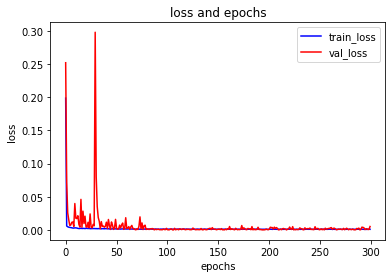

In [75]:
plt.title("loss and epochs")
plt.plot(history.history['loss'],color = 'blue',label="train_loss")
plt.plot(history.history['val_loss'],color = 'red',label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


In [76]:
# #Load the minimum loss weight 
# model = get_bi_gru()
# model.load_weights("./saved_model/the_best_one.h5")

In [77]:
# # Load saved model 
# from tensorflow.keras.models import load_model
# model = load_model("./saved_model/the_best_one.h5")

In [78]:
x_train.shape
y_train.shape

(7088, 10)

In [79]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [80]:
print(y_test_pred[0])

[0.36383772 0.36846223 0.35348195 0.35985407 0.35525358 0.3509404
 0.36107245 0.3217777  0.36748752 0.51652473]


In [81]:
print( y_test_pred[:, 1][0])

0.36846223


In [82]:
def plot_compare(x):
    Col = {'Open':0, 'High':1, 'Low':2, 'Close':3}
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
            y_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
            y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price')
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices '+x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')



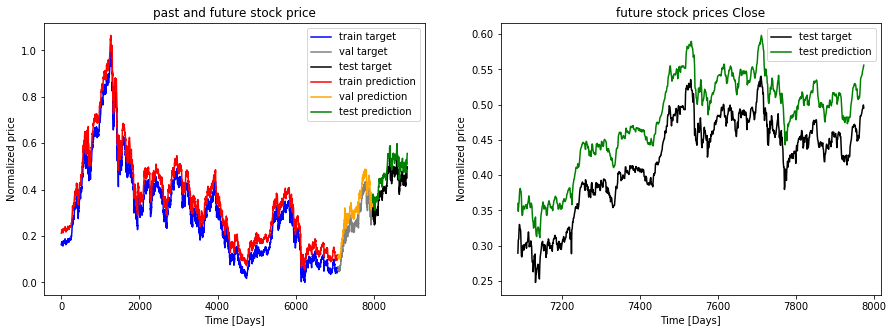

In [83]:
plot_compare('Close')

In [84]:
model.save("saved_model/best_one.h5")

In [85]:
model.evaluate(x_test,y_test)

886/886 [==============================] - 0s 492us/sample - loss: 0.0053 - mean_squared_error: 0.0053


[0.005268501086290883, 0.0052685016]

In [86]:
model.evaluate(x_val,y_val)

886/886 [==============================] - 1s 576us/sample - loss: 0.0052 - mean_squared_error: 0.0052


[0.005209206832619068, 0.005209207]

In [87]:
model.evaluate(x_train,y_train)

7088/7088 [==============================] - 4s 621us/sample - loss: 0.0052 - mean_squared_error: 0.0052


[0.005174416526269092, 0.0051744147]